# Overall flow 

1. Get the ground truth bounding boxes

2. Find the dimensions of the scene/ 8 corners of the scene, along with the center of the scene

3. Partition the scene into **n** spatial zones, divide the length, breadth, height by **2n** which will be the per-zone increment outwards from the center
    * Output: (n, 3, 2) : where n is the number of zones, 3 is the 3 axes, 2 being the upper and lower bounds for each zone.
    * Plot lines that demarcate the n spatial zones in a scene.
    * Plot pcd and GT bounding boxes to verify if the allocation of spatial zones are accurate.

4. Check which zone a GT bounding box falls under
    * Input: center of a GT bounding box, zones of shape  (n, 3, 2) : where n is the number of zones, 3 is the 3 axes, 2 being the upper and lower bounds for each zone.

    * Output: int indicating the zone for the bounding box

5.  For a scene:
    * For each GT bounding box in the scene:
        * Get the center of the bounding box
        * Call function to find which zone the GT bounding box falls under
        * Have a mapping of Zone: GT bounding boxes

## Getting the GT Bounding boxes

### Helper functions and objects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scannet_base import ScannetBaseDataset
from scannet_val import ScannetValDataset
import open3d as o3d
import os

train_dataset = ScannetBaseDataset(num_points=40000,
                                     augment=False)

val_dataset = ScannetValDataset(all_classes=True,
                                    num_novel_class=9,
                                    num_points=40000,
                                    augment=False)

classes = ['bathtub', 'bed', 'bookshelf', 'cabinet', 'chair', 'counter', 'curtain', 'desk', 'door', 'otherfurniture',
                      'picture', 'refrigerator', 'showercurtain', 'sink', 'sofa', 'table', 'toilet', 'window']

box_sizes = {'cabinet': np.array([0.76966726, 0.81160211, 0.92573741]),
                       'bed': np.array([1.876858, 1.84255952, 1.19315654]),
                       'chair': np.array([0.61327999, 0.61486087, 0.71827014]),
                       'sofa': np.array([1.39550063, 1.51215451, 0.83443565]),
                       'table': np.array([0.97949596, 1.06751485, 0.63296875]),
                       'door': np.array([0.53166301, 0.59555772, 1.75001483]),
                       'window': np.array([0.96247056, 0.72462326, 1.14818682]),
                       'bookshelf': np.array([0.83221924, 1.04909355, 1.68756634]),
                       'picture': np.array([0.21132214, 0.4206159 , 0.53728459]),
                       'counter': np.array([1.44400728, 1.89708334, 0.26985747]),
                       'desk': np.array([1.02942616, 1.40407966, 0.87554322]),
                       'curtain': np.array([1.37664116, 0.65521793, 1.68131292]),
                       'refrigerator': np.array([0.66508189, 0.71111926, 1.29885307]),
                       'showercurtain': np.array([0.41999174, 0.37906947, 1.75139715]),
                       'toilet': np.array([0.59359559, 0.59124924, 0.73919014]),
                       'sink': np.array([0.50867595, 0.50656087, 0.30136236]),
                       'bathtub': np.array([1.15115265, 1.0546296 , 0.49706794]),
                       'otherfurniture': np.array([0.47535286, 0.49249493, 0.58021168])
                        }

color_name_to_rgb = {
    'red': [1.0, 0.0, 0.0],
    'green': [0.0, 1.0, 0.23529411764705882],
    'blue': [0.0, 0.4705882352941176, 1.0],
    'purple': [0.7058823529411765, 0.0, 1.0],
    'orange': [1.0, 0.23529411764705882, 0.0],
    'lime': [0.23529411764705882, 1.0, 0.0],
    'cyan': [0.0, 0.7058823529411765, 1.0],
    'magenta': [0.4705882352941176, 0.0, 1.0],
    'pink': [1.0, 0.0, 0.4705882352941176],
    'yellow': [0.4705882352941176, 1.0, 0.0],
    'skyblue': [0.0, 0.9411764705882353, 1.0],
    'indigo': [0.23529411764705882, 0.0, 1.0],
    'hotpink': [1.0, 0.0, 0.7058823529411765],
    'chartreuse': [0.7058823529411765, 1.0, 0.0],
    'aquamarine': [0.0, 1.0, 0.7058823529411765],
    'royalblue': [0.0, 0.23529411764705882, 1.0],
    'violet': [0.9411764705882353, 0.0, 1.0],
    'gold': [1.0, 0.4705882352941176, 0.0],
    'black': [0.0, 0.0, 0.0],
}

class_to_color_name = {
    'bathtub': 'black',
    'bed': 'green',
    'bookshelf': 'blue',
    'cabinet': 'purple',
    'chair': 'orange',
    'counter': 'lime',
    'curtain': 'cyan',
    'desk': 'magenta',
    'door': 'pink',
    'otherfurniture': 'yellow',
    'picture': 'skyblue',
    'refrigerator': 'indigo',
    'showercurtain': 'hotpink',
    'sink': 'chartreuse',
    'sofa': 'aquamarine',
    'table': 'royalblue',
    'toilet': 'violet',
    'window': 'gold',
}
    

def flip_axis_to_camera(pc):
    ''' Flip X-right,Y-forward,Z-up to X-right,Y-down,Z-forward
    Input and output are both (N,3) array
    '''
    pc2 = np.copy(pc)
    pc2[...,[0,1,2]] = pc2[...,[0,2,1]] # cam X,Y,Z = depth X,-Z,Y
    pc2[...,1] *= -1
    return pc2

def flip_axis_to_depth(pc):
    pc2 = np.copy(pc)
    pc2[...,[0,1,2]] = pc2[...,[0,2,1]] # depth X,Y,Z = cam X,Z,-Y
    pc2[...,2] *= -1
    return pc2

# Function to create a bounding box LineSet from center, heading, and size
def create_bbox(center, heading, size, color):
    corners = np.array([
        [-size[0]/2, -size[1]/2, -size[2]/2],
        [ size[0]/2, -size[1]/2, -size[2]/2],
        [ size[0]/2,  size[1]/2, -size[2]/2],
        [-size[0]/2,  size[1]/2, -size[2]/2],
        [-size[0]/2, -size[1]/2,  size[2]/2],
        [ size[0]/2, -size[1]/2,  size[2]/2],
        [ size[0]/2,  size[1]/2,  size[2]/2],
        [-size[0]/2,  size[1]/2,  size[2]/2],
    ])
    
    # Rotate the corners according to the heading
    cos_theta = np.cos(heading)
    sin_theta = np.sin(heading)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, cos_theta, -sin_theta],
        [0, sin_theta, cos_theta]
    ])
    rotated_corners = np.dot(corners, rotation_matrix.T)
    
    # Translate corners to the center
    corners =  center - rotated_corners
    
    # Create LineSet
    lines = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical lines
    ]
    colors = [color for _ in range(len(lines))]  # Red color for all lines
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(corners),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    
    return line_set


# Function to create a bounding box LineSet from corners
def create_bbox_from_corners(corners, color):
    lines = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical lines
    ]
    colors = [color for _ in range(len(lines))]  # Same color for all lines
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(corners),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    
    return line_set

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Training classes: ['bathtub', 'bed', 'bookshelf', 'cabinet', 'chair', 'counter', 'curtain', 'desk', 'door'] | number of scenes: 1165
VALIDATION_DATA_PATH: /home/peisheng/SDCoT/scannet/scannet_val_detection_data
Testing classes: ['bathtub', 'bed', 'bookshelf', 'cabinet', 'chair', 'counter', 'curtain', 'desk', 'door', 'otherfurniture', 'picture', 'refrigerator', 'showercurtain', 'sink', 'sofa', 'table', 'toilet', 'window'] | number of scenes: 312


In [2]:
def get_gt_bboxes(img_id, dataset_type="val"):
    
    
    if dataset_type == "val":
        dataset = val_dataset
        
    elif dataset_type == "train":
        dataset = train_dataset
    
    data = dataset[img_id]
    
    scanname = dataset.scan_names[img_id]
    print(scanname)
    
    center_label = data["center_label"]
    heading_class_label = data["heading_class_label"]
    heading_residual_label = data["heading_residual_label"]
    size_residual_label = data["size_residual_label"]
    sem_cls_label = data["sem_cls_label"]
    pcd = data["point_clouds"]
    
    pcd_flipped = flip_axis_to_camera(pcd)
    pcd_flipped = flip_axis_to_depth(pcd_flipped)
    
    # print("pcd_flipped shape: ", pcd_flipped.shape)
    
    # print("No. of GT bboxes before removing duplicates: ", len(center_label))
    
    centers = []
    
    
    for i in range(len(center_label)):
        center = center_label[i]
        heading = heading_class_label[i] * (2 * np.pi / 12) + heading_residual_label[i]
        classname = classes[sem_cls_label[i]]
        size = box_sizes[classname] + size_residual_label[i]
        
        # Remove duplicate filler boxes, which have center at [0, 0, 0]:
        if np.array_equal(center, np.array([0., 0., 0.])) and classname=="bathtub":
            continue
        
        centers.append((i, center, classname))
    
    # print("No. of GT bboxes after removing: ", len(centers))
    
    return centers

In [3]:
centers = get_gt_bboxes(46)     # List( (index, center, classname) )

scene0146_00


In [4]:
print(centers)

[(0, array([-0.7182697,  1.2471408,  0.6583613], dtype=float32), 'otherfurniture'), (1, array([0.6342453 , 0.82686526, 0.49707964], dtype=float32), 'toilet'), (2, array([ 0.71425563, -0.31277555,  0.6422175 ], dtype=float32), 'sink'), (3, array([-0.10494043, -1.6142914 ,  0.90692395], dtype=float32), 'door')]


## Finding the dimensions and center of the scene

In [5]:
from sklearn.neighbors import NearestNeighbors

def get_scene_dimensions_center(img_id, dataset_type="val"):
    
    if dataset_type == "val":
        dataset = val_dataset
        
    elif dataset_type == "train":
        dataset = train_dataset
    
    data = dataset[img_id]
    
    scanname = dataset.scan_names[img_id]
    
    pcd = data["point_clouds"]
    pcd_flipped = flip_axis_to_camera(pcd)
    pcd_flipped = flip_axis_to_depth(pcd_flipped)
    
    # Compute the minimum and maximum values along each axis
    min_coords = np.min(pcd_flipped, axis=0)
    max_coords = np.max(pcd_flipped, axis=0)
    
    # Calculate the dimensions of the scene (length, breadth, height)
    dimensions = max_coords - min_coords
    
    x, y, z = dimensions
    # print(f"x: {x}")
    # print(f"y: {y}")
    # print(f"z: {z}")
    
    # Calculate the center of the scene
    center = (max_coords + min_coords) / 2
    # print(f"Center: {center}")
    
    # Plot the point cloud and the center of the scene
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(pcd_flipped)
    
    # Nearest Neighbors to map pcd_noRGB_flipped to points
    pcd_ply = o3d.io.read_point_cloud(f"../../../../mnt/data/Datasets/ScanNet_v2/scans/{scanname}/{scanname}_vh_clean_2.ply")
    points = np.asarray(pcd_ply.points)
    colors = np.asarray(pcd_ply.colors)
    
    k = 10
    nn = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    distances, indices = nn.kneighbors(pcd_flipped)
    
    # Calculate the weighted average of the RGB values
    weights = 1 / (distances + 1e-8)  # Avoid division by zero
    weights /= weights.sum(axis=1, keepdims=True)  # Normalize weights
    
    # Compute the weighted average of RGB values
    rgb_vals = np.zeros((pcd_flipped.shape[0], 3))
    for i in range(k):
        rgb_vals += colors[indices[:, i]] * weights[:, i:i+1]
        
    point_cloud.colors = o3d.utility.Vector3dVector(rgb_vals)
        
    gt_entities = [point_cloud]
    
    # Create a sphere at the center of the scene
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.1)
    
    # Translate the sphere to the center of the scene
    sphere.translate(center)
    
    # Add the sphere to the list of entities
    gt_entities.append(sphere)
    
    # o3d.visualization.draw_plotly(gt_entities)
    
    return dimensions, center, gt_entities

In [6]:
(dimensions, center, gt_entities) = get_scene_dimensions_center(46)

## Divide scene into spatial zones

In [7]:
def divide_scene(n, dimensions, center):
    
    # Calculate the per-zone increment
    increment = dimensions / (2 * n)

    # Initialize the output array
    zones = np.zeros((n, 3, 2))

    # Calculate the bounds for each zone
    for i in range(n):
        for axis in range(3):
            lower_bound = center[axis] - (i + 1) * increment[axis]
            upper_bound = center[axis] + (i + 1) * increment[axis]
            zones[i, axis, 0] = lower_bound
            zones[i, axis, 1] = upper_bound

    # print("Zones:\n", zones)
    
    return zones

In [8]:
zones = divide_scene(4, dimensions, center)

### Plotting point cloud with spatial zoning boxes and centers of bounding boxes

In [9]:
from plotly.colors import sample_colorscale

# Function to create a box from lower and upper bounds of each zone
def create_box_linetraces(zones):
    line_traces = []
    # Sample colors from a Plotly colorscale
    colors = sample_colorscale("Viridis", [i / len(zones) for i in range(len(zones))])
    
    for i in range(zones.shape[0]):
        lower_bound = zones[i, :, 0]
        upper_bound = zones[i, :, 1]
        points = [
            [lower_bound[0], lower_bound[1], lower_bound[2]],
            [upper_bound[0], lower_bound[1], lower_bound[2]],
            [upper_bound[0], upper_bound[1], lower_bound[2]],
            [lower_bound[0], upper_bound[1], lower_bound[2]],
            [lower_bound[0], lower_bound[1], upper_bound[2]],
            [upper_bound[0], lower_bound[1], upper_bound[2]],
            [upper_bound[0], upper_bound[1], upper_bound[2]],
            [lower_bound[0], upper_bound[1], upper_bound[2]],
        ]
        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],
            [4, 5], [5, 6], [6, 7], [7, 4],
            [0, 4], [1, 5], [2, 6], [3, 7]
        ]
        
        for line in lines:
            x = [points[line[0]][0], points[line[1]][0]]
            y = [points[line[0]][1], points[line[1]][1]]
            z = [points[line[0]][2], points[line[1]][2]]
            line_traces.append(
                go.Scatter3d(
                    x=x, y=y, z=z,
                    mode='lines',
                    line=dict(color=colors[i], width=5)  # Increase line width here
                )
            )
    return line_traces

In [10]:
import plotly.graph_objects as go

def plot_scene_go(zones, centers, gt_entities): 
    line_sets = create_box_linetraces(zones)

    # Create point cloud trace
    points = np.asarray(gt_entities[0].points)
    point_cloud_trace = go.Scatter3d(
        x=points[:, 0], y=points[:, 1], z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='grey', opacity=0.4)  # Adjust point size and color
    )

    # Create trace for ground truth bounding box centers
    bbox_indexes = [center[0] for center in centers]
    bbox_centers = np.array([center[1] for center in centers])
    bbox_classes = [center[2] for center in centers]
    # Create hover text with index and class name
    hover_texts = [f"Index: {idx}<br>Class: {cls}" for idx, cls in zip(bbox_indexes, bbox_classes)]

    # Create trace for ground truth bounding box centers with class names and indexes
    bbox_centers_trace = go.Scatter3d(
        x=bbox_centers[:, 0], y=bbox_centers[:, 1], z=bbox_centers[:, 2],
        mode='markers',
        marker=dict(size=12, color='red', opacity=1),  # Adjust marker size, color, and opacity
        text=hover_texts,  # Add class names and indexes for hover text
        hoverinfo='text',  # Display the text on hover
        name='BBox Centers'
    )

    # Combine all traces
    fig = go.Figure(data=[point_cloud_trace] + line_sets + [bbox_centers_trace])

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Partitions'
    )

    # Show the plot
    fig.show()

In [11]:
# Function to create a box from lower and upper bounds of each zone
def create_box_linesets(zones):
    line_sets = []
    for i in range(zones.shape[0]):
        lower_bound = zones[i, :, 0]
        upper_bound = zones[i, :, 1]
        points = [
            [lower_bound[0], lower_bound[1], lower_bound[2]],
            [upper_bound[0], lower_bound[1], lower_bound[2]],
            [upper_bound[0], upper_bound[1], lower_bound[2]],
            [lower_bound[0], upper_bound[1], lower_bound[2]],
            [lower_bound[0], lower_bound[1], upper_bound[2]],
            [upper_bound[0], lower_bound[1], upper_bound[2]],
            [upper_bound[0], upper_bound[1], upper_bound[2]],
            [lower_bound[0], upper_bound[1], upper_bound[2]],
        ]
        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],
            [4, 5], [5, 6], [6, 7], [7, 4],
            [0, 4], [1, 5], [2, 6], [3, 7]
        ]
        colors = [[1, 0, 0] for _ in range(len(lines))]  # Red color for all lines
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(points)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector(colors)
        line_sets.append(line_set)
    return line_sets

def plot_scene_o3d(zones, centers, gt_entities):
    line_sets = create_box_linesets(zones)

    for line_set in line_sets:
        gt_entities.append(line_set)
        
    # Add the GT bounding boxes' centers to the list of entities as spheres
    for i, center, classname in centers:
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.08)
        sphere.translate(center)
        sphere.paint_uniform_color(color_name_to_rgb[class_to_color_name[classname]])
        gt_entities.append(sphere)
        
    o3d.visualization.draw_plotly(gt_entities)

## Get the zone a bounding box falls in

In [12]:
def get_zone_for_bbox(bbox_center, zones):
    """
    Determines the zone index for a given bounding box center.

    Parameters:
    - bbox_center: A numpy array of shape (3,) representing the center coordinates [x, y, z] of the bounding box.
    - zones: A numpy array of shape (n, 3, 2) representing the zones. 
             n is the number of zones, 3 is the 3 axes (x, y, z), and 2 is the lower and upper bounds for each zone.

    Returns:
    - zone_index: An integer indicating the zone index for the bounding box center. 
                  Returns -1 if the bbox_center does not fall within any zone.
    """
    for i in range(zones.shape[0]):
        if (zones[i, 0, 0] <= bbox_center[0] <= zones[i, 0, 1] and
            zones[i, 1, 0] <= bbox_center[1] <= zones[i, 1, 1] and
            zones[i, 2, 0] <= bbox_center[2] <= zones[i, 2, 1]):
            return i
    return -1  # Return -1 if no zone matches the bounding box center

## Get the zones of all bounding boxes in a scene

In [13]:
def get_zones_for_gt_bboxes(scene, n_zones, dataset_type="val", plot_viz=False):
    """
    Determines the zone index for each ground truth bounding box in the scene.

    Parameters:
    - scene: A dictionary containing the scene information.

    Returns:
    - zone_mapping: A dictionary mapping the bounding box index to the zone index.
    """
    bbox_centers = get_gt_bboxes(scene, dataset_type=dataset_type)     # List( (index, center, classname) )
    (scene_dimensions, scene_center, gt_entities) = get_scene_dimensions_center(scene, dataset_type=dataset_type)
    zones = divide_scene(n_zones, scene_dimensions, scene_center)
    
    if plot_viz:
        plot_scene_o3d(zones, bbox_centers, gt_entities)
        plot_scene_go(zones, bbox_centers, gt_entities)
    
    # Initialize the zone mapping
    zone_mapping = {}
    
    # Determine the zone for each bounding box
    for i, center, classname in bbox_centers:
        zone_index = get_zone_for_bbox(center, zones) + 1  # Add 1 to make the zone index 1-based
        zone_mapping[i] = classname, zone_index
        
    # print("Zone Mapping:\n", zone_mapping)
    
    return zone_mapping # Dictionary( bbox_index: (classname, zone_index) )

In [ ]:
get_zones_for_gt_bboxes(46, 4, plot_viz=True)

# Get the distribution of spatial zones in the Val Dataset

In [15]:
def get_all_zone_mappings(n=4, dataset_type="val"):

    if dataset_type == "val":
        dataset = ScannetValDataset(all_classes=True,
                                    num_novel_class=9,
                                    num_points=40000,
                                    augment=False)

    elif dataset_type == "train":
        dataset = ScannetBaseDataset(num_points=40000,
                                     augment=False)
        
    zone_mappings = {}
    
    # print(dataset.scan_names)

    for i, scanname in enumerate(dataset.scan_names):
        # print("Index: ", i, " Scanname: ", scanname)
        
        zone_mapping = get_zones_for_gt_bboxes(i, n, dataset_type=dataset_type)
        
        zone_mappings[scanname] = zone_mapping
        
    return zone_mappings # Dictionary( scanname: Dictionary( bbox_index: (classname, zone_index) ) )

In [16]:
val_zone_mappings = get_all_zone_mappings(n=4, dataset_type="val")

VALIDATION_DATA_PATH: /home/peisheng/SDCoT/scannet/scannet_val_detection_data
Testing classes: ['bathtub', 'bed', 'bookshelf', 'cabinet', 'chair', 'counter', 'curtain', 'desk', 'door', 'otherfurniture', 'picture', 'refrigerator', 'showercurtain', 'sink', 'sofa', 'table', 'toilet', 'window'] | number of scenes: 312
scene0011_00
scene0011_01
scene0015_00
scene0019_00
scene0019_01
scene0025_00
scene0025_01
scene0025_02
scene0030_00
scene0030_01
scene0030_02
scene0046_00
scene0046_01
scene0046_02
scene0050_00
scene0050_01
scene0050_02
scene0063_00
scene0064_00
scene0064_01
scene0077_00
scene0077_01
scene0081_00
scene0081_01
scene0081_02
scene0084_00
scene0084_01
scene0084_02
scene0086_00
scene0086_01
scene0086_02
scene0088_00
scene0088_01
scene0088_02
scene0088_03
scene0095_00
scene0095_01
scene0100_00
scene0100_01
scene0100_02
scene0131_00
scene0131_01
scene0131_02
scene0139_00
scene0144_00
scene0144_01
scene0146_00
scene0146_01
scene0146_02
scene0149_00
scene0153_00
scene0153_01
scene016

In [17]:
print(val_zone_mappings.keys())

dict_keys(['scene0011_00', 'scene0011_01', 'scene0015_00', 'scene0019_00', 'scene0019_01', 'scene0025_00', 'scene0025_01', 'scene0025_02', 'scene0030_00', 'scene0030_01', 'scene0030_02', 'scene0046_00', 'scene0046_01', 'scene0046_02', 'scene0050_00', 'scene0050_01', 'scene0050_02', 'scene0063_00', 'scene0064_00', 'scene0064_01', 'scene0077_00', 'scene0077_01', 'scene0081_00', 'scene0081_01', 'scene0081_02', 'scene0084_00', 'scene0084_01', 'scene0084_02', 'scene0086_00', 'scene0086_01', 'scene0086_02', 'scene0088_00', 'scene0088_01', 'scene0088_02', 'scene0088_03', 'scene0095_00', 'scene0095_01', 'scene0100_00', 'scene0100_01', 'scene0100_02', 'scene0131_00', 'scene0131_01', 'scene0131_02', 'scene0139_00', 'scene0144_00', 'scene0144_01', 'scene0146_00', 'scene0146_01', 'scene0146_02', 'scene0149_00', 'scene0153_00', 'scene0153_01', 'scene0164_00', 'scene0164_01', 'scene0164_02', 'scene0164_03', 'scene0169_00', 'scene0169_01', 'scene0187_00', 'scene0187_01', 'scene0193_00', 'scene0193_01

### Plot distribution of GT bboxes by spatial zones

In [18]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_overall_zone_dist(zone_mappings, dataset_type="val"):
    # Extract zone indices
    zone_indices = []

    for scanname, bbox_dict in zone_mappings.items():
        for bbox_index, (classname, zone_index) in bbox_dict.items():
            zone_indices.append(zone_index)

    # Count occurrences of each zone index
    zone_counts = Counter(zone_indices)

    print("Zone Counts:\n", zone_counts)

    # Plot the distribution
    zone_indices_sorted = sorted(zone_counts.keys())
    zone_counts_sorted = [zone_counts[zi] for zi in zone_indices_sorted]

    plt.bar(zone_indices_sorted, zone_counts_sorted, width=0.8, align='center')
    plt.xticks(zone_indices_sorted)  # Ensures discrete ticks
    plt.xlabel('Zone Index')
    plt.ylabel('Number of Bounding Boxes')
    if dataset_type == "val":
        plt.title('Distribution of Bounding Boxes Across Zones (Validation Set)')
        
    elif dataset_type == "train":
        plt.title('Distribution of Bounding Boxes Across Zones (Training Set)')

    # Add counts on top of each bar
    for i, count in enumerate(zone_counts_sorted):
        plt.text(zone_indices_sorted[i], count, str(count), ha='center', va='bottom')

    plt.show()

Zone Counts:
 Counter({3: 1900, 4: 1885, 2: 534, 1: 45})


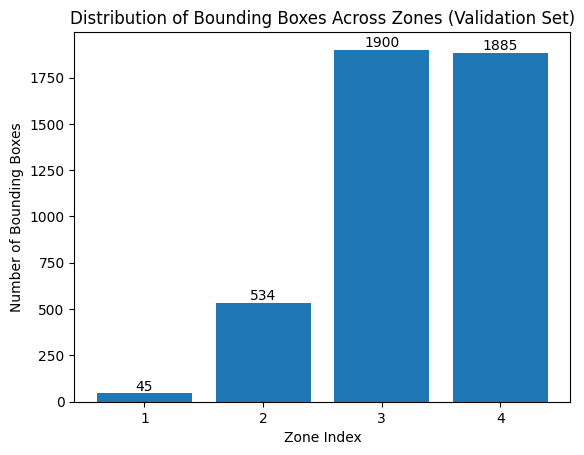

In [19]:
plot_overall_zone_dist(val_zone_mappings)

## Plot GT bboxes by spatial zones and classnames

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

def plot_zone_dist_by_class_heatmap(zone_mappings, dataset_type="val"):

    counts = defaultdict(int)
    for scanname, bbox_dict in zone_mappings.items():
        for bbox_index, (classname, zone_index) in bbox_dict.items():
            counts[(classname, zone_index)] += 1

    # Convert the dictionary to a DataFrame
    df_counts = pd.DataFrame(list(counts.items()), columns=['ClassZone', 'Count'])
    df_counts[['Classname', 'ZoneIndex']] = pd.DataFrame(df_counts['ClassZone'].tolist(), index=df_counts.index)
    df_counts = df_counts.pivot(index='Classname', columns='ZoneIndex', values='Count').fillna(0).astype(int)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_counts, annot=True, fmt="d", cmap="YlGnBu")
    if dataset_type == "val":
        plt.title('Distribution of Bounding Boxes by Classname and Zone Index (Validation Set)')
    elif dataset_type == "train":
        plt.title('Distribution of Bounding Boxes by Classname and Zone Index (Training Set)')
    plt.xlabel('Zone Index')
    plt.ylabel('Classname')
    plt.show()

def plot_zone_dist_by_class_stackedbars(zone_mappings, dataset_type="val"):
    # Create a dictionary to count occurrences of each (classname, zone_index) pair
    
    counts = defaultdict(int)
    for scanname, bbox_dict in zone_mappings.items():
        for bbox_index, (classname, zone_index) in bbox_dict.items():
            counts[(classname, zone_index)] += 1

    # Convert the dictionary to a DataFrame
    df_counts = pd.DataFrame(list(counts.items()), columns=['ClassZone', 'Count'])
    df_counts[['Classname', 'ZoneIndex']] = pd.DataFrame(df_counts['ClassZone'].tolist(), index=df_counts.index)
    df_counts = df_counts.pivot(index='Classname', columns='ZoneIndex', values='Count').fillna(0)

    # Plot the stacked bar graph
    df_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
    if dataset_type == "val":
        plt.title('Distribution of Bounding Boxes by Classname and Zone Index (Validation Set)')
    elif dataset_type == "train":
        plt.title('Distribution of Bounding Boxes by Classname and Zone Index (Training Set)')
    plt.xlabel('Classname')
    plt.ylabel('Count')
    plt.legend(title='Zone Index')
    plt.show()


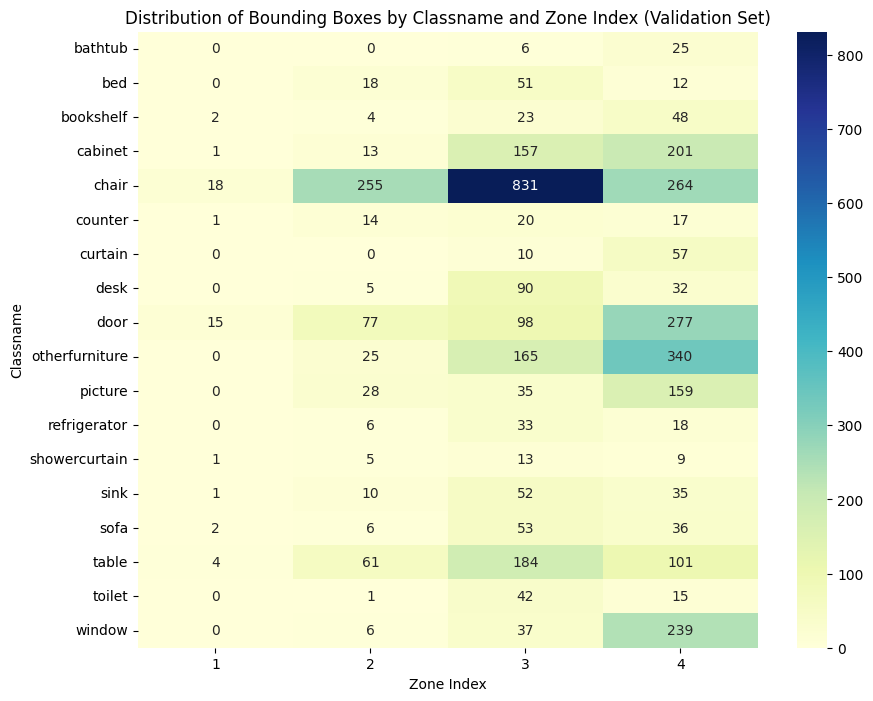

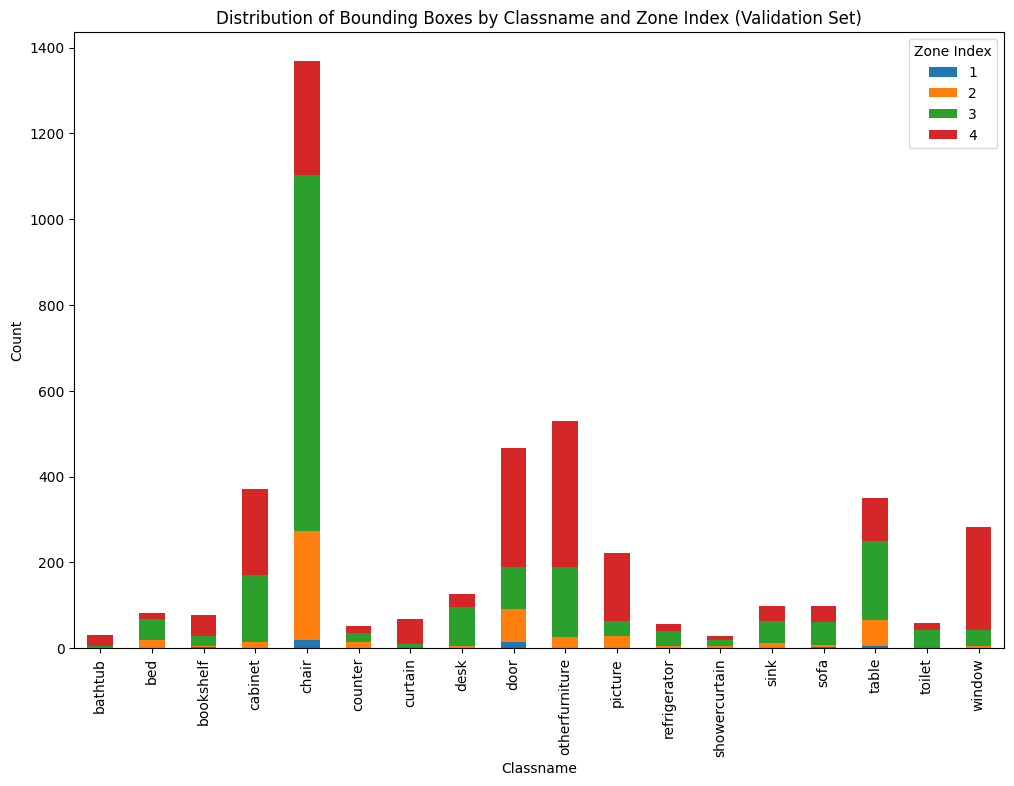

In [22]:
plot_zone_dist_by_class_heatmap(val_zone_mappings)
plot_zone_dist_by_class_stackedbars(val_zone_mappings)

# Get the distribution of spatial zones in the Train Dataset

In [23]:
train_zone_mappings = get_all_zone_mappings(n=4, dataset_type="train")

Training classes: ['bathtub', 'bed', 'bookshelf', 'cabinet', 'chair', 'counter', 'curtain', 'desk', 'door'] | number of scenes: 1165
scene0026_00
scene0282_01
scene0309_00
scene0279_02
scene0561_01
scene0570_01
scene0409_01
scene0274_02
scene0385_02
scene0332_00
scene0073_01
scene0439_00
scene0123_02
scene0409_00
scene0155_01
scene0669_01
scene0572_00
scene0027_00
scene0561_00
scene0473_01
scene0160_03
scene0348_02
scene0009_02
scene0301_01
scene0031_01
scene0512_00
scene0233_00
scene0238_00
scene0369_00
scene0673_05
scene0127_01
scene0455_00
scene0260_02
scene0286_02
scene0604_02
scene0286_03
scene0241_02
scene0459_01
scene0368_00
scene0545_02
scene0323_01
scene0372_00
scene0646_00
scene0466_00
scene0662_02
scene0263_00
scene0540_01
scene0478_01
scene0370_01
scene0592_01
scene0226_00
scene0362_00
scene0385_01
scene0250_00
scene0419_00
scene0538_00
scene0097_00
scene0282_02
scene0381_02
scene0436_00
scene0482_01
scene0281_00
scene0177_02
scene0037_00
scene0434_00
scene0516_00
scene0654

## Plot GT bboxes by spatial zones

Zone Counts:
 Counter({3: 4519, 4: 3708, 2: 1267, 1: 95})


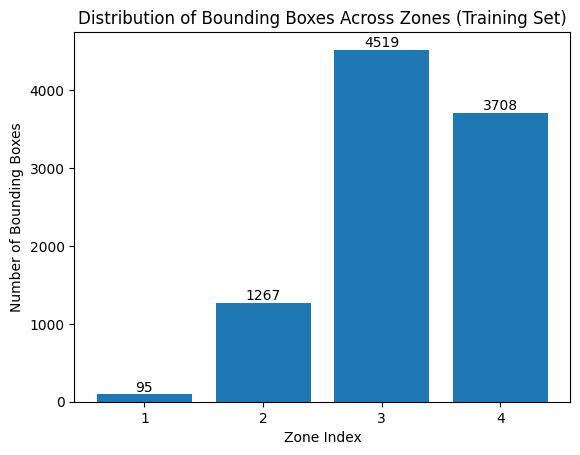

In [24]:
plot_overall_zone_dist(train_zone_mappings, dataset_type="train")

## Plot GT bboxes by spatial zones and classnames

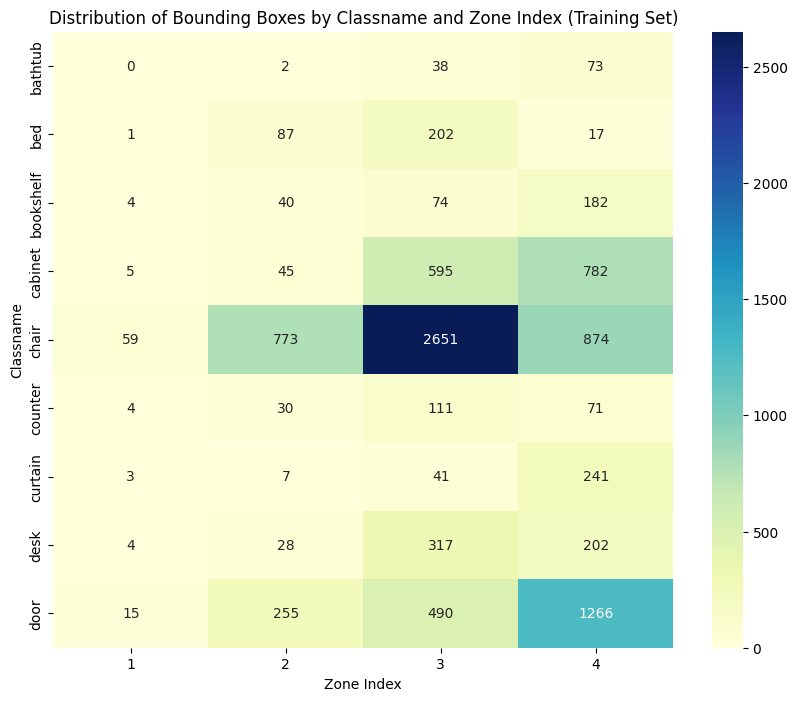

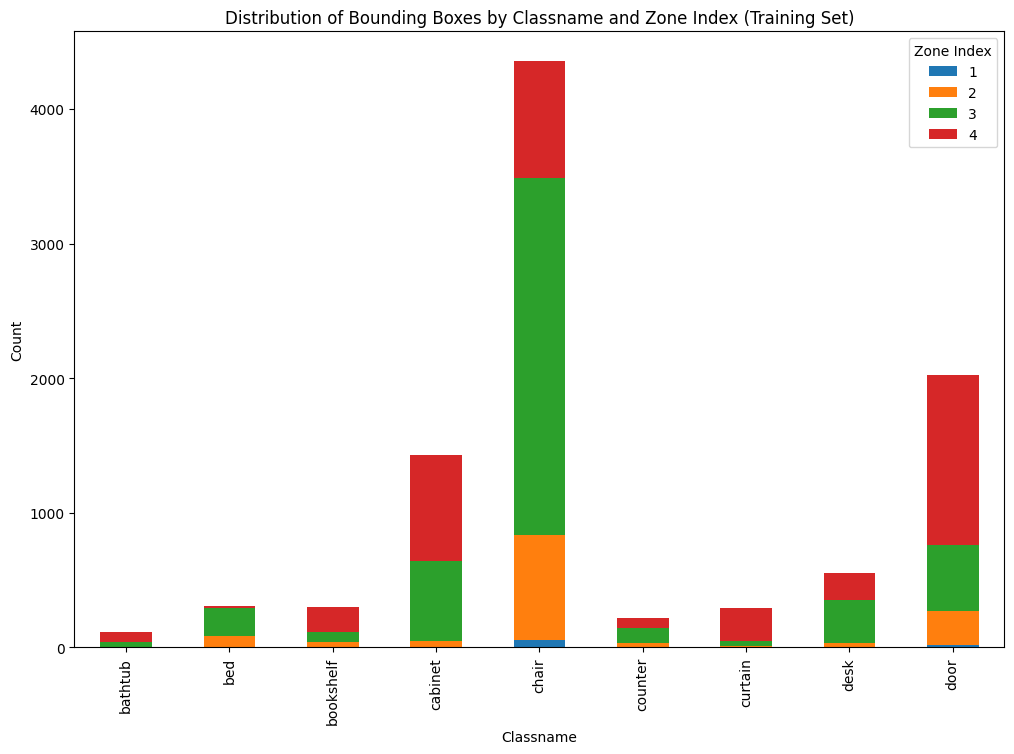

In [25]:
plot_zone_dist_by_class_heatmap(train_zone_mappings, dataset_type="train")
plot_zone_dist_by_class_stackedbars(train_zone_mappings, dataset_type="train")

## Check the number of GT bboxes that belong to the 9 base classes

In [32]:
print(val_zone_mappings['scene0146_00'])

train_set_classes = ['bathtub', 'bed', 'bookshelf', 'cabinet', 'chair', 'counter', 'curtain', 'desk', 'door']

# Find out how many bounding boxes are there in the validation set that have classes that are present in the training set
def get_base_class_counts(zone_mappings, train_set_classes):
    base_class_counts = defaultdict(int)
    for scanname, bbox_dict in zone_mappings.items():
        for bbox_index, (classname, zone_index) in bbox_dict.items():
            if classname in train_set_classes:
                base_class_counts[classname] += 1
    return base_class_counts

class_counts = get_base_class_counts(val_zone_mappings, train_set_classes)
sum_counts = sum(class_counts.values())
print("Base Class Counts:\n", class_counts)
print("Total Base Class Counts: ", sum_counts)

{0: ('otherfurniture', 4), 1: ('toilet', 3), 2: ('sink', 3), 3: ('door', 4)}
Base Class Counts:
 defaultdict(<class 'int'>, {'cabinet': 372, 'chair': 1368, 'counter': 52, 'door': 467, 'desk': 127, 'bookshelf': 77, 'bathtub': 31, 'bed': 81, 'curtain': 67})
Total Base Class Counts:  2642


# Merge spatial zones index with ground truth accuracy results from base training evaluation

In [36]:
gt_df_basetrain = pd.read_csv("/home/peisheng/SDCoT/ground_truth_object_results/gt_df_results_basetrain.csv")

In [37]:
print(sorted(val_zone_mappings.keys()))

['scene0011_00', 'scene0011_01', 'scene0015_00', 'scene0019_00', 'scene0019_01', 'scene0025_00', 'scene0025_01', 'scene0025_02', 'scene0030_00', 'scene0030_01', 'scene0030_02', 'scene0046_00', 'scene0046_01', 'scene0046_02', 'scene0050_00', 'scene0050_01', 'scene0050_02', 'scene0063_00', 'scene0064_00', 'scene0064_01', 'scene0077_00', 'scene0077_01', 'scene0081_00', 'scene0081_01', 'scene0081_02', 'scene0084_00', 'scene0084_01', 'scene0084_02', 'scene0086_00', 'scene0086_01', 'scene0086_02', 'scene0088_00', 'scene0088_01', 'scene0088_02', 'scene0088_03', 'scene0095_00', 'scene0095_01', 'scene0100_00', 'scene0100_01', 'scene0100_02', 'scene0131_00', 'scene0131_01', 'scene0131_02', 'scene0139_00', 'scene0144_00', 'scene0144_01', 'scene0146_00', 'scene0146_01', 'scene0146_02', 'scene0149_00', 'scene0153_00', 'scene0153_01', 'scene0164_00', 'scene0164_01', 'scene0164_02', 'scene0164_03', 'scene0169_00', 'scene0169_01', 'scene0187_00', 'scene0187_01', 'scene0193_00', 'scene0193_01', 'scene0

In [38]:
def get_spatial_zone(row, spatial_zones):
    return spatial_zones.get(row['scan_name'], None).get(row['gt_index'], None)[1]

# Add the spatial_zone column
gt_df_basetrain['spatial_zone'] = gt_df.apply(lambda x: get_spatial_zone(x, val_zone_mappings), axis=1)

display(gt_df_basetrain)

,img_id,scan_name,classname,gt_index,has_pred_bbox,spatial_zone
0,0,scene0207_01,counter,0,True,3
1,0,scene0207_01,bed,1,True,3
2,0,scene0207_01,door,2,True,4
3,0,scene0207_01,door,3,True,3
4,0,scene0207_01,door,4,True,2
...,...,...,...,...,...,...
2637,311,scene0088_01,chair,14,True,4
2638,311,scene0088_01,chair,15,True,4
2639,311,scene0088_01,chair,16,True,3
2640,311,scene0088_01,chair,17,True,3


In [40]:
gt_df_basetrain.to_csv("/home/peisheng/SDCoT/ground_truth_object_results/gt_df_results_basetrain_spatialzones.csv", index=False)

# Merge spatial zones index with ground truth accuracy results from SDCoT evaluation

In [42]:
gt_df_sdcot = pd.read_csv("/home/peisheng/SDCoT/ground_truth_object_results/gt_df_results_SDCoT.csv")

# Add the spatial_zone column
gt_df_sdcot['spatial_zone'] = gt_df_sdcot.apply(lambda x: get_spatial_zone(x, val_zone_mappings), axis=1)

display(gt_df_sdcot)

,img_id,scan_name,classname,gt_index,has_pred_bbox,spatial_zone
0,0,scene0500_01,table,0,True,3
1,0,scene0500_01,table,1,True,4
2,0,scene0500_01,chair,2,True,3
3,0,scene0500_01,chair,3,True,3
4,0,scene0500_01,chair,4,True,4
...,...,...,...,...,...,...
4359,311,scene0580_00,bed,4,True,3
4360,311,scene0580_00,table,5,True,3
4361,311,scene0580_00,otherfurniture,6,False,4
4362,311,scene0580_00,door,7,False,4


In [ ]:
gt_df_sdcot.to_csv("/home/peisheng/SDCoT/ground_truth_object_results/gt_df_results_SDCoT_spatialzones.csv", index=False)